# Feature Selection: Filtering Methodology 

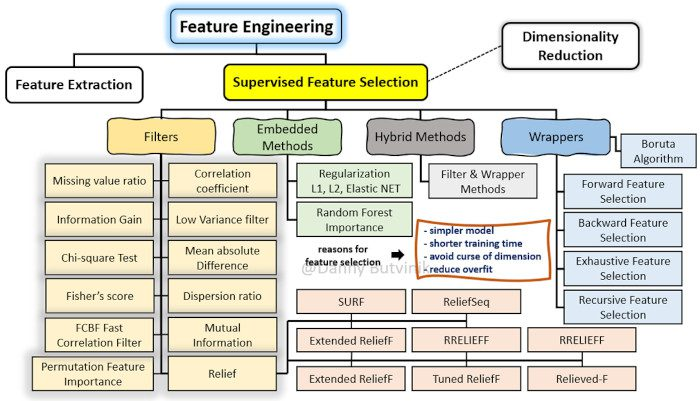

In [274]:
Image(filename='Fig3-Butvinik-feature-selection-overview.jpg', width=1500, height=100) 

In [158]:
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [273]:
#Importing useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from copy import deepcopy
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import LabelEncoder
from warnings import filterwarnings
from IPython.display import Image
filterwarnings(action = 'ignore')
%matplotlib inline

In [258]:
raw = pd.read_csv('diamonds.csv')
df = deepcopy(raw)

#### Our goal is to find the specifications of the most expensive diamonds. For this we'll conduct some statistical and visual tests to filter out insignificant features and discover what makes a diamond more expensive 

In [259]:
df.sample(6)

,carat,cut,color,clarity,depth,table,price,x,y,z
49863,0.71,Premium,I,SI1,60.2,58.0,2173,5.83,5.76,3.49
25188,2.01,Ideal,I,SI2,62.5,55.0,13777,8.12,8.08,5.06
19429,1.23,Ideal,H,VVS2,62.0,55.0,8079,6.85,6.90,4.26
52379,0.70,Very Good,G,VS2,61.9,55.0,2507,5.63,5.71,3.51
33077,0.26,Premium,E,VVS1,60.9,59.0,814,4.12,4.09,2.50
4142,0.90,Premium,H,SI1,62.7,58.0,3545,6.14,6.20,3.87


In [260]:
#First of all, our data is vast, so let's shrink it's memory usage and continue 
display(df.shape[0], df.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 12.2 MB


53940

None

In [261]:
def reduce_memory_usage(data, pct_threshold=0.5): 
    '''Can be reapplied after 
    outlier handling and scaling'''
    
    start_mem = data.memory_usage().sum() / 1024**2
    print('Memory usage before: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != 'object':
            c_min = data[col].min()
            c_max = data[col].max()
            if 'int' in str(col_type): 
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)
        
        elif col_type=='object':
            if data[col].nunique() / data[col].shape[0] < pct_threshold:  
                data[col] = data[col].astype('category') 
            else:
                continue

    end_mem = data.memory_usage().sum() / 1024**2
    print('Memory usage now : {:.2f} MB'.format(end_mem))
    print('Memory usage decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

In [262]:
#Since this is done, let's move on
reduce_memory_usage(df)

Memory usage before: 4.12 MB
Memory usage now : 0.88 MB
Memory usage decreased by 78.7%


In [263]:
#Now
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float16 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float16 
 5   table    53940 non-null  float16 
 6   price    53940 non-null  int16   
 7   x        53940 non-null  float16 
 8   y        53940 non-null  float16 
 9   z        53940 non-null  float16 
dtypes: category(3), float16(6), int16(1)
memory usage: 896.5 KB


In [264]:
continuous_features = list(df.select_dtypes(include='number').columns)
continuous_features

['carat', 'depth', 'table', 'price', 'x', 'y', 'z']

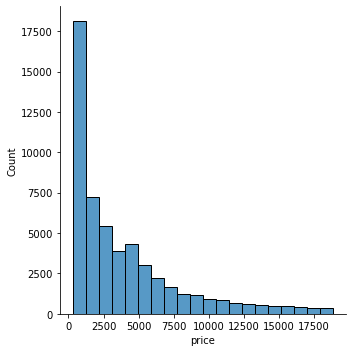

In [167]:
#Evidently, the most expensive ones are few
sns.displot(df['price'], bins=20)
plt.show()

In [278]:
df[continuous_features].corr(method='pearson')['price'].to_frame().sort_values(by='price', ascending=False).iloc[1:,:]

,price
carat,0.921586
x,0.884435
y,0.865415
z,0.861247
table,0.127135
depth,-0.010657


#### Pearson test is sensitive to outliers because so is the global mean which is used in the calculation of Covariance 

In [266]:
def find_outlier_records(data, column_name: str, no_std=3):
  assert (column_name in data.columns)
  no_outliers = 0 
  values = data[column_name].unique() 
  upper_border = np.asarray(data[column_name]).mean() + no_std*(np.asarray(data[column_name]).std())
  lower_border = np.asarray(data[column_name]).mean() - no_std*(np.asarray(data[column_name]).std()) 
  for value in values:
    if value>upper_border:
      no_outliers+=int(data[column_name].value_counts()[value])
    elif value<lower_border:
      no_outliers+=int(data[column_name].value_counts()[value])
    else:
      continue
  print(f'''Number of outlier records in {column_name} column: {no_outliers}''')   

In [267]:
for feat in continuous_features:
    find_outlier_records(df, column_name=feat)

Number of outlier records in carat column: 439
Number of outlier records in depth column: 0
Number of outlier records in table column: 0
Number of outlier records in price column: 1206
Number of outlier records in x column: 0
Number of outlier records in y column: 0
Number of outlier records in z column: 0


#### The price column has considerable skewness. Let's check all of our continuous column's normality with qqplot

In [56]:
def normality_visual(data):
    for column in data.columns:
        fig = qqplot(data[column], line = '45', fit=True)
        ax = plt.gca() 
        fig.set_size_inches(15, 8) 
        ax.set_xlabel('Theoretical Quantiles', fontsize=13)
        ax.set_ylabel(f'Sample Quantiles of the {column} column', fontsize=13)
        plt.show()

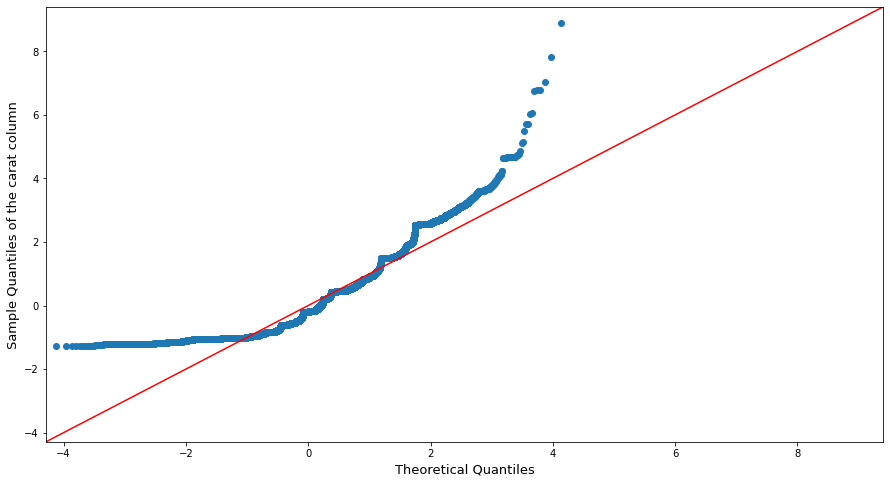

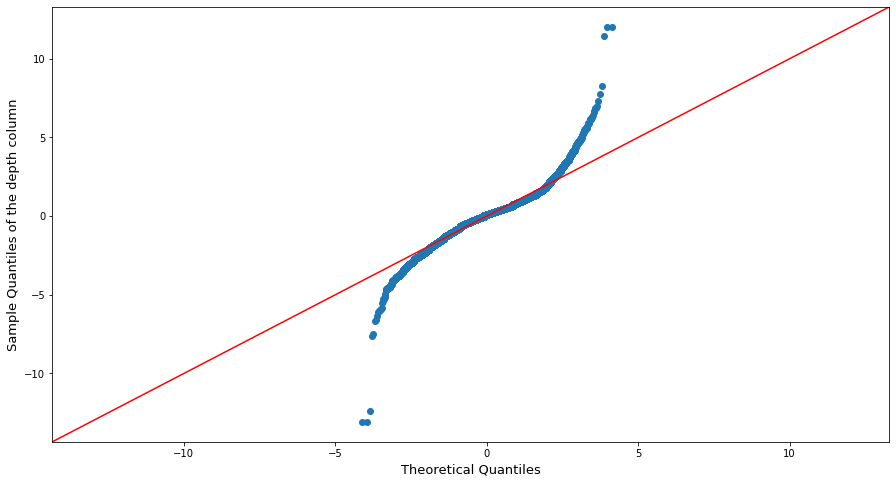

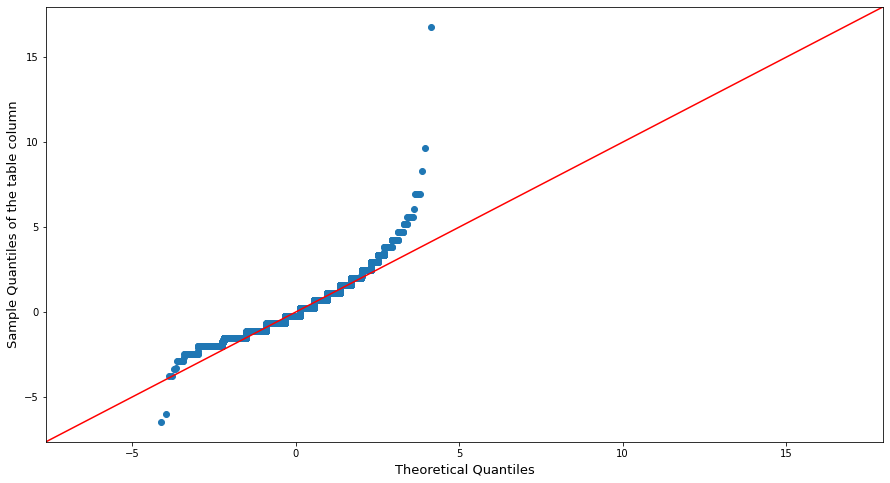

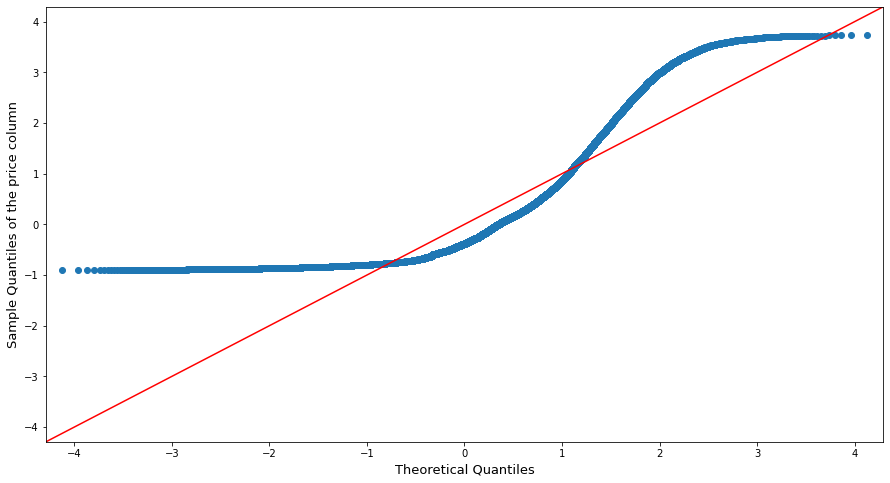

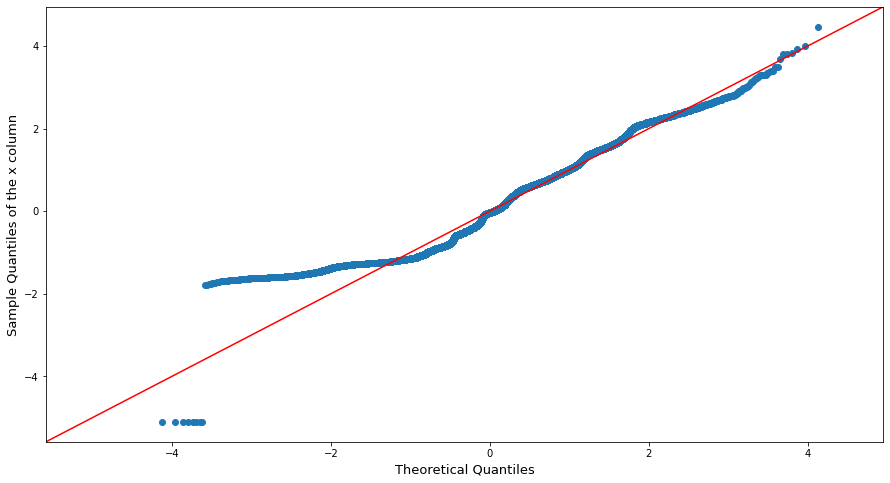

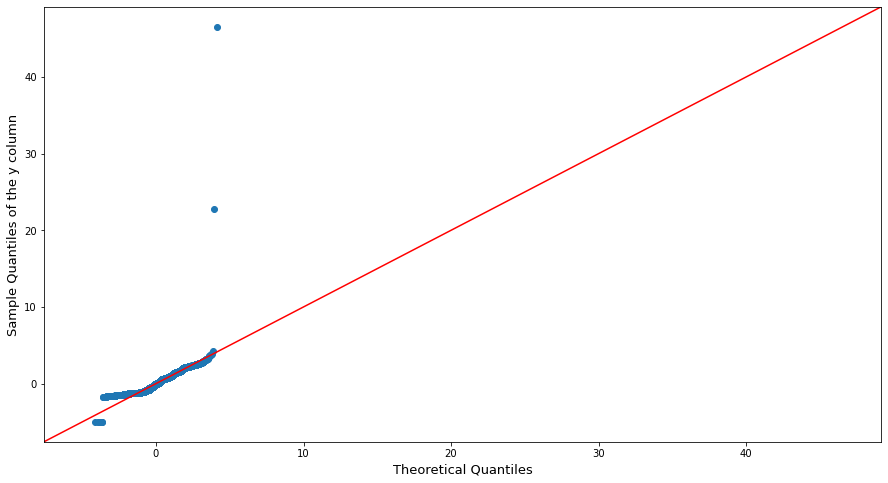

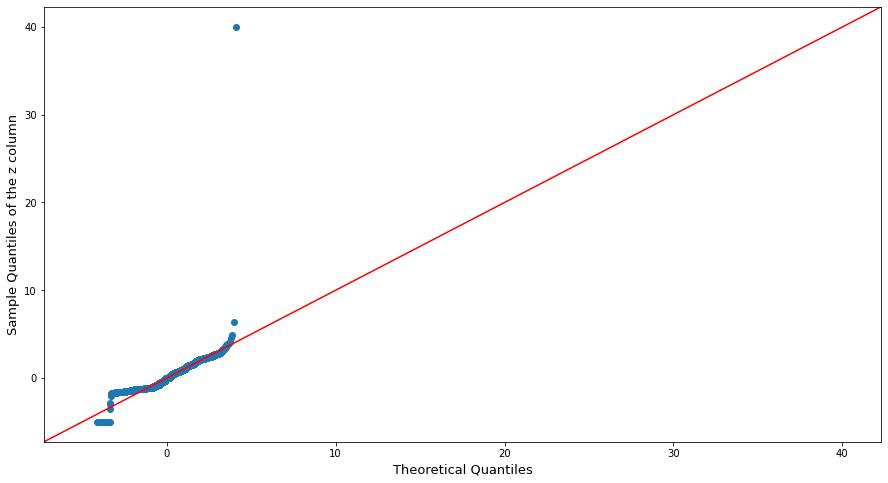

In [59]:
normality_visual(df[continuous_features])

#### Since our Price column clearly violates the normality test, it would be more apt to go with a non-parametric test of Spearman. But for that we ought to check for a monotous relationship which denotes either an increasing or decreasing trend.

In [87]:
def linearity_corr(data, column1: str, column2: str):
    sns.regplot(x = column1, y = column2, data=data, color='b') 
    plt.show()

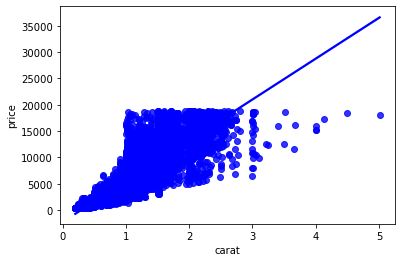

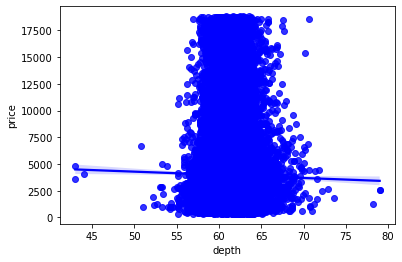

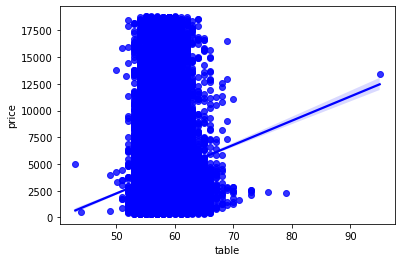

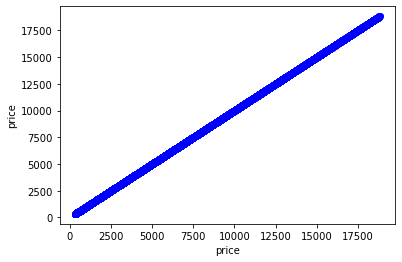

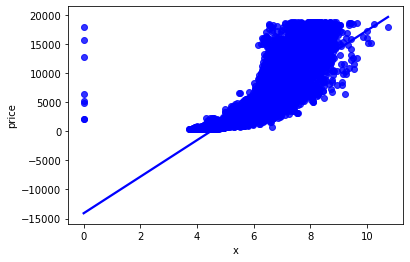

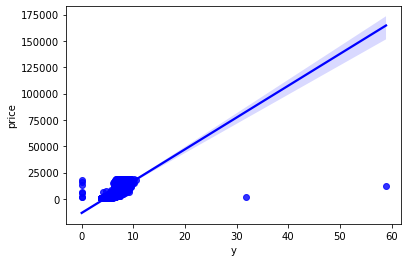

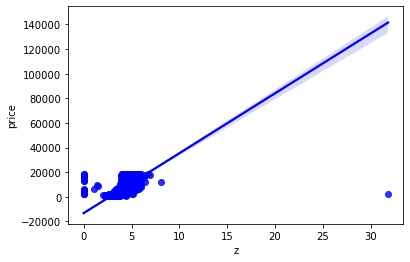

In [89]:
for feat in continuous_features:
    linearity_corr(df, column1=feat, column2='price')

In [268]:
#Only table and depth features have little to no correlation in this dataset
df[continuous_features].corr(method='spearman')['price'].to_frame().sort_values(by='price', ascending=False).iloc[1:,:]

,price
x,0.963196
carat,0.962883
y,0.962719
z,0.957232
table,0.171784
depth,0.010020


In [269]:
ordinal_features = list(df.select_dtypes(include='category').columns)

In [270]:
le = LabelEncoder()
for feat in ordinal_features:
    df[feat] = le.fit_transform(df[feat])

In [271]:
ordinal_features.append('price')

In [272]:
#It turns out only the first four continuous features are significant characteristics
df[ordinal_features].corr(method='spearman')['price'].to_frame().sort_values(by='price', ascending=False).iloc[1:,:]

,price
color,0.150142
cut,0.038185
clarity,-0.116206


#### Lastly, to visualise our findings above, let's plot another scatter plot to show that there're are almost no correlation when the order (level) shifts. Usually this is done between two continuous features like above, but ordinal-continuous may give some insight as well

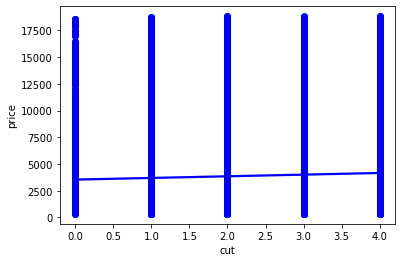

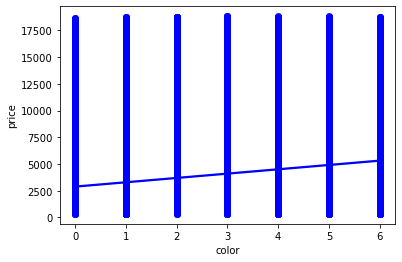

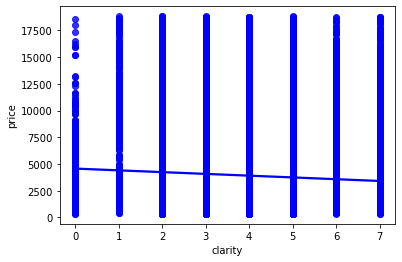

In [277]:
for feat in ordinal_features[:-1]:
    linearity_corr(df, column1=feat, column2='price')